## MACD Cross Over Strategy

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
from datetime import datetime as dt

plt.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

### Get Data From Binance API

In [5]:
def get_klines(symbol, interval, limit=500):
    url = 'https://fapi.binance.com/fapi/v1/klines'
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    
    data = pd.DataFrame(json.loads(requests.get(url, params=params).text))
    data = data.iloc[:,0:6]
    data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    data['Open Time'] = [dt.fromtimestamp(x / 1000) for x in data['Open Time']]
    data['Open'] = data['Open'].astype(float)
    data['High'] = data['High'].astype(float)
    data['Low'] = data['Low'].astype(float)
    data['Close'] = data['Close'].astype(float)
    
    return data

In [6]:
data = get_klines('BTCUSDT', '15m', 500)
data

,Open Time,Open,High,Low,Close,Volume
0,2023-12-30 19:00:00,42522.1,42550.9,42405.0,42440.4,2343.614
1,2023-12-30 19:15:00,42440.5,42495.7,42428.0,42432.8,1135.212
2,2023-12-30 19:30:00,42432.8,42465.1,42367.8,42380.1,1436.018
3,2023-12-30 19:45:00,42380.1,42479.9,42365.0,42446.7,1259.400
4,2023-12-30 20:00:00,42446.8,42446.8,42375.0,42392.9,1008.389
...,...,...,...,...,...,...
495,2024-01-04 22:45:00,44258.1,44448.9,44237.6,44434.1,2148.348
496,2024-01-04 23:00:00,44434.1,44633.8,44413.1,44626.3,3463.714
497,2024-01-04 23:15:00,44626.3,44754.6,44458.9,44464.3,6255.142
498,2024-01-04 23:30:00,44464.4,44467.9,44269.1,44374.0,3077.871


### Implement the indicators

In [9]:
def get_macd(data, slow, fast, smooth):
    fast_ema = data['Close'].ewm(span=fast, adjust=False).mean()
    slow_ema = data['Close'].ewm(span=slow, adjust=False).mean()
    macd = pd.DataFrame(fast_ema - slow_ema).rename(columns={'Close': 'macd'})
    signal = pd.DataFrame(macd.ewm(span=smooth, adjust=False).mean()).rename(columns={'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns={0:'hist'})
    frames = [data, macd, signal, hist]
    df = pd.concat(frames, join='inner', axis=1)
    return df

In [10]:
data_macd = get_macd(data, 26, 12, 9)
data_macd

,Open Time,Open,High,Low,Close,Volume,macd,signal,hist
0,2023-12-30 19:00:00,42522.1,42550.9,42405.0,42440.4,2343.614,0.000000,0.000000,0.000000
1,2023-12-30 19:15:00,42440.5,42495.7,42428.0,42432.8,1135.212,-0.606268,-0.121254,-0.485014
2,2023-12-30 19:30:00,42432.8,42465.1,42367.8,42380.1,1436.018,-5.278344,-1.152672,-4.125672
3,2023-12-30 19:45:00,42380.1,42479.9,42365.0,42446.7,1259.400,-3.565829,-1.635303,-1.930526
4,2023-12-30 20:00:00,42446.8,42446.8,42375.0,42392.9,1008.389,-6.475217,-2.603286,-3.871931
...,...,...,...,...,...,...,...,...,...
495,2024-01-04 22:45:00,44258.1,44448.9,44237.6,44434.1,2148.348,169.528215,166.262662,3.265552
496,2024-01-04 23:00:00,44434.1,44633.8,44413.1,44626.3,3463.714,189.310284,170.872187,18.438097
497,2024-01-04 23:15:00,44626.3,44754.6,44458.9,44464.3,6255.142,189.728597,174.643469,15.085128
498,2024-01-04 23:30:00,44464.4,44467.9,44269.1,44374.0,3077.871,180.690767,175.852928,4.837839


### Plot the data

In [13]:
def plot_macd(data):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)
    
    ax1.plot(data['Close'], color='black', linewidth=1.5, label='Price')
    ax2.plot(data['macd'], color='green', linewidth=1.5, label='MACD')
    ax2.plot(data['signal'], color='blue', linewidth=1.5, label='Signal')
    
    for i in range(len(data)):
        if str(data['hist'][i])[0] == '-':
            ax2.bar(data.index[i], data['hist'][i], color='#ef5350')
        else:
            ax2.bar(data.index[i], data['hist'][i], color='#26a69a')
            
    plt.legend(loc='lower right')

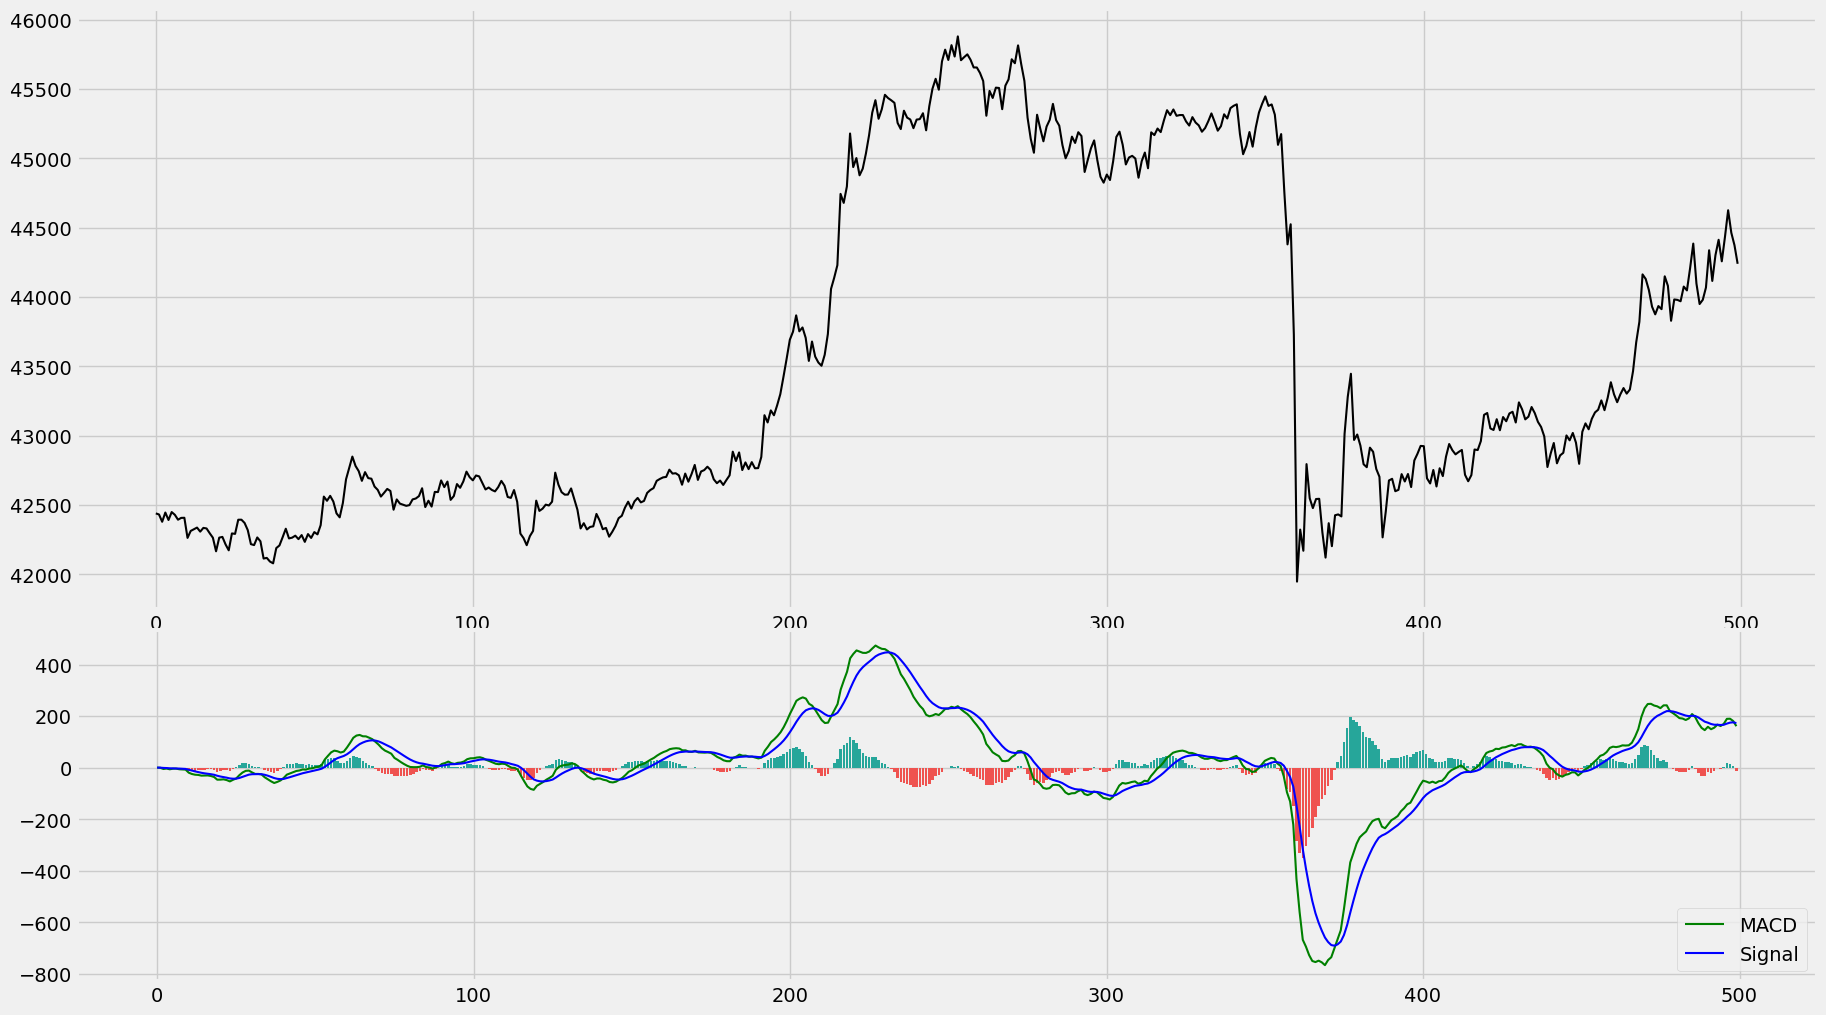

In [14]:
plot_macd(data_macd)

### Implement the strategy

In [17]:
def implement_strategy(data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data['Close'][i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

In [19]:
buy_price, sell_price, macd_signal = implement_strategy(data_macd)
data_macd['signal'] = macd_signal
data_macd

,Open Time,Open,High,Low,Close,Volume,macd,signal,hist
0,2023-12-30 19:00:00,42522.1,42550.9,42405.0,42440.4,2343.614,0.000000,0,0.000000
1,2023-12-30 19:15:00,42440.5,42495.7,42428.0,42432.8,1135.212,-0.606268,-1,-0.485014
2,2023-12-30 19:30:00,42432.8,42465.1,42367.8,42380.1,1436.018,-5.278344,0,-4.125672
3,2023-12-30 19:45:00,42380.1,42479.9,42365.0,42446.7,1259.400,-3.565829,0,-1.930526
4,2023-12-30 20:00:00,42446.8,42446.8,42375.0,42392.9,1008.389,-6.475217,0,-3.871931
...,...,...,...,...,...,...,...,...,...
495,2024-01-04 22:45:00,44258.1,44448.9,44237.6,44434.1,2148.348,169.528215,1,3.265552
496,2024-01-04 23:00:00,44434.1,44633.8,44413.1,44626.3,3463.714,189.310284,0,18.438097
497,2024-01-04 23:15:00,44626.3,44754.6,44458.9,44464.3,6255.142,189.728597,0,15.085128
498,2024-01-04 23:30:00,44464.4,44467.9,44269.1,44374.0,3077.871,180.690767,0,4.837839


### Plot the signals

In [22]:
def plot_macd_signals(data, buy_price, sell_price):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1)
    
    ax1.plot(data['Close'], color='black', linewidth=1.5, label='BTC Price')
    ax1.plot(data.index, buy_price, marker='^', color='green', markersize=10, label='Buy Signal', linewidth=0)
    ax1.plot(data.index, sell_price, marker='v', color='red', markersize=10, label='Sell Signal', linewidth=0)
    ax1.legend()
    ax1.set_title('BTC MACD Signals')
    
    ax2.plot(data['macd'], color='grey', linewidth=1.5, label='MACD')
    ax2.plot(data['signal'], color='blue', linewidth=1.5, label='Signal')
    
    for i in range(len(data)):
        if str(data['hist'][i])[0] == '-':
            ax2.bar(data.index[i], data['hist'][i], color='#ef5350')
        else:
            ax2.bar(data.index[i], data['hist'][i], color='#26a69a')
            
    plt.legend(loc='lower right')


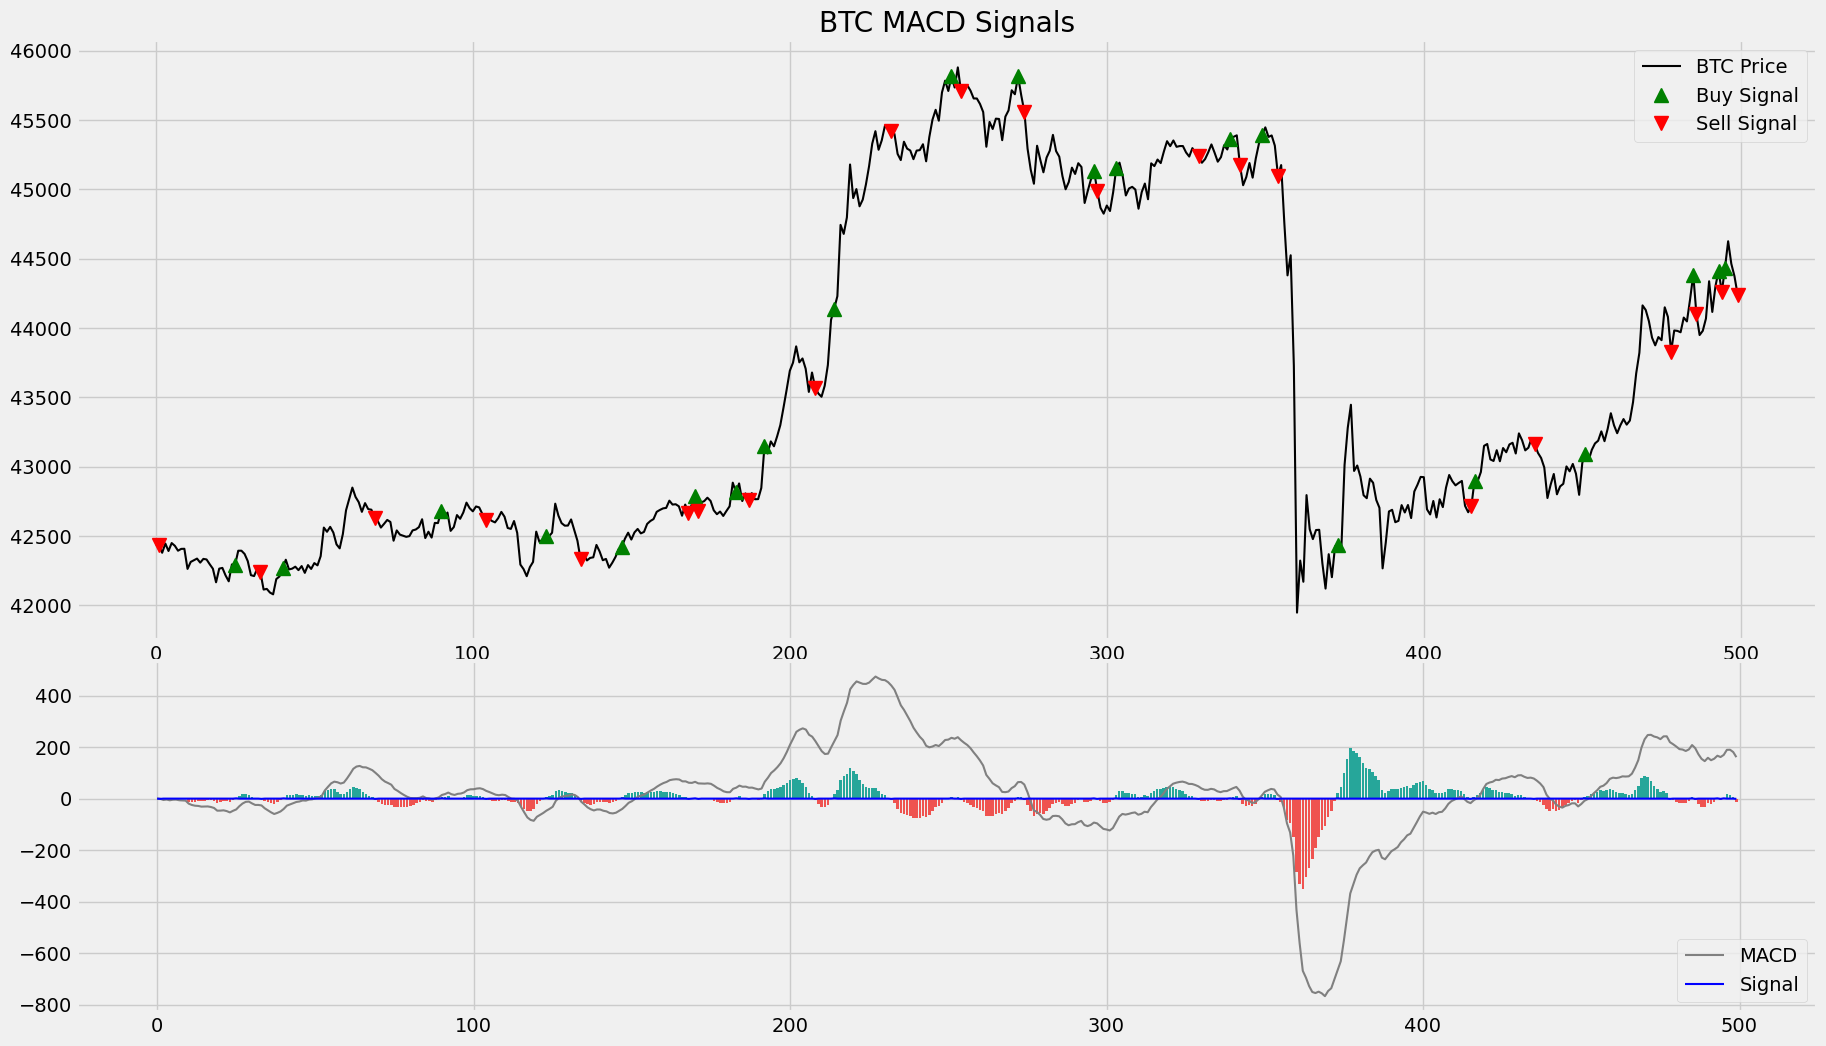

In [24]:
plot_macd_signals(data_macd, buy_price, sell_price)